# Question Q9

*Question*: How were requirements typically elicited in the ML-enabled system projects you participated in?

*Answer Type*: Multiple Option and Free Field

*Options*: [Interviews, Scenarios, Prototyping, Facilitated meetings (including workshops), Observation, Other please specify]

### Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
from utils.basic import rename_values, format_wordcloud_text
from utils.dataframe import DataframeUtils
from utils.plot import PlotUtils
from utils.bootstrapping import BootstrappingUtils

### Dataframe Init

In [2]:
dataframe_obj = DataframeUtils('./data/main_data.csv', ';', './data/unused_columns.txt', './data/formatted_columns.txt')
# the index is not important, but when we internally format df we need to reset index
dataframe_obj.df = dataframe_obj.df.reset_index(drop=True)

In [3]:
# For PROFES, we discarded suspended submissions (e.g., remove those who didn't complete the survey).
dataframe_obj.df.drop(dataframe_obj.df[dataframe_obj.df['Status'] == 'Suspended (22)'].index, inplace = True)

In [4]:
# question options
requirements = {
    'Q9_ML_Elicitation_Interviews': 'Interviews',
    'Q9_ML_Elicitation_Scenarios': 'Scenarios',
    'Q9_ML_Elicitation_Prototyping': 'Prototyping',
    'Q9_ML_Elicitation_Workshops_Meetings': 'Workshops Meetings',
    'Q9_ML_Elicitation_Observation': 'Obseervation',
    'Q9_ML_Elicitation_Others': 'Others'
}

### Basic Analysis

In [5]:
dataframe_obj.df[['Q9_ML_Elicitation_Interviews', 'Q9_ML_Elicitation_Scenarios', 
                  'Q9_ML_Elicitation_Prototyping', 'Q9_ML_Elicitation_Workshops_Meetings', 
                  'Q9_ML_Elicitation_Observation', 'Q9_ML_Elicitation_Others', 'Q9_ML_Elicitation_Others_Free']].head()

,Q9_ML_Elicitation_Interviews,Q9_ML_Elicitation_Scenarios,Q9_ML_Elicitation_Prototyping,Q9_ML_Elicitation_Workshops_Meetings,Q9_ML_Elicitation_Observation,Q9_ML_Elicitation_Others,Q9_ML_Elicitation_Others_Free
0,not quoted,not quoted,quoted,not quoted,not quoted,not quoted,-99
1,not quoted,quoted,not quoted,not quoted,not quoted,not quoted,-99
2,quoted,quoted,not quoted,quoted,not quoted,quoted,Literature
3,quoted,not quoted,quoted,not quoted,not quoted,not quoted,-99
4,quoted,quoted,quoted,quoted,not quoted,not quoted,-99


In [6]:
indexes = []
values = []
chart_positions = []
for requirement in requirements:
    indexes.append(requirements[requirement])
    values.append(dataframe_obj.df[requirement].value_counts()['quoted'])
    chart_positions.append(1 if '_Others' not in requirement else 0)

In [7]:
# compute total of unique answers in this question
total = 0
for idx, row in dataframe_obj.df.iterrows():
    
    if row['Q9_ML_Elicitation_Interviews'] == 'quoted' or row['Q9_ML_Elicitation_Scenarios'] == 'quoted' or row['Q9_ML_Elicitation_Prototyping'] == 'quoted' or row['Q9_ML_Elicitation_Workshops_Meetings'] == 'quoted' or row['Q9_ML_Elicitation_Observation'] == 'quoted' or row['Q9_ML_Elicitation_Others'] == 'quoted':
        total += 1

total_answers = 'N = ' + str(total)
total_answers_int = total

In [8]:
# plot object
q9_plot = PlotUtils(pd.DataFrame(
    data={'Requirements': indexes, 'Answers': values, 'Chart Position': chart_positions}
).sort_values(by=['Chart Position', 'Answers'], ascending=False))

C:\Users\Antonio Pedro Alves\.virtualenvs\pfp-antonio-pedro-lcinjCty\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


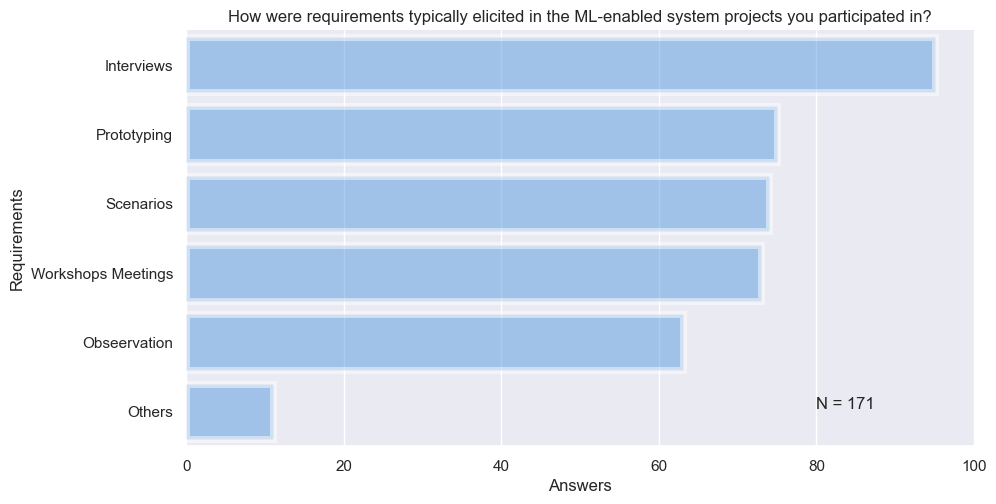

In [9]:
q9_plot.single_barplot(x_axis="Answers", y_axis="Requirements",
                       title="How were requirements typically elicited in the ML-enabled system projects you participated in?",
                       x_label="Answers", y_label="Requirements", x_label_rotation=0, color="#429bf5", total_answers=total_answers)

#### WordCloud

In [10]:
# remove unnecessary values
requirements_free = list(filter(lambda a: str(a) != '-99', 
                           list(dataframe_obj.df['Q9_ML_Elicitation_Others_Free'])))
requirements_free = list(filter(lambda a: str(a) != '-66', requirements_free))
requirements_free = list(filter(lambda a: str(a) != 'nan', requirements_free))

In [11]:
requirements_words = format_wordcloud_text(texts=requirements_free, use_sep=False)

In [12]:
# plot object
q9_wc_plot = PlotUtils(pd.DataFrame(
    data={'Word': list(requirements_words.keys()), 'Weight': list(requirements_words.values())}
))

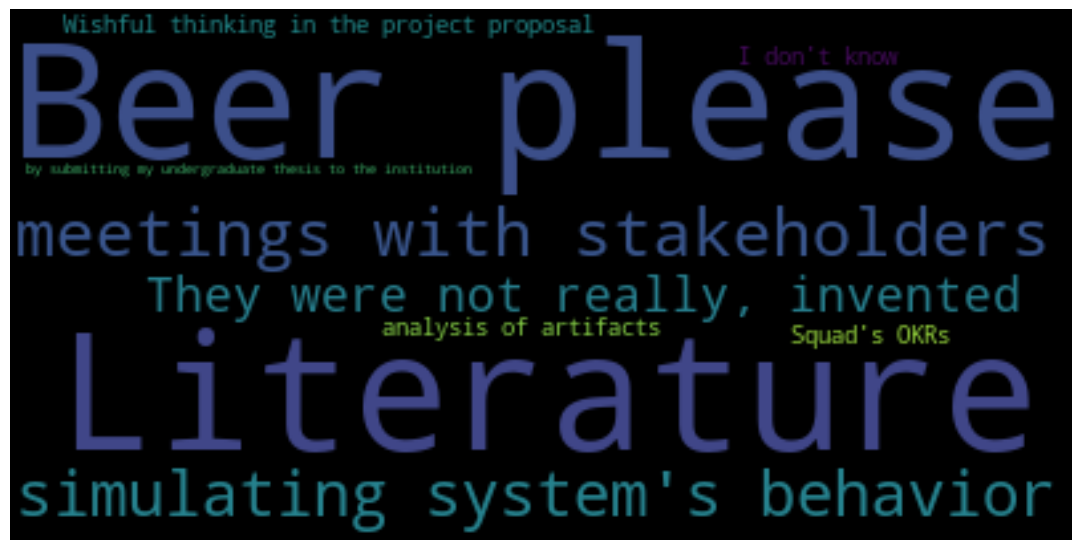

In [13]:
q9_wc_plot.wordcloud("Word", 'Weight')

### Bootstrapping Analysis

In [14]:
prefix = "Q9_ML_Elicitation_"

In [15]:
# the possible answers are the ones in columns
valid_options_list = [requirement_column.split(prefix)[1] for requirement_column in requirements]

In [16]:
# answers could be composed by more than one option, so we will have an array of selected options
valid_answers_list = []
for idx, row in dataframe_obj.df.iterrows():
    answer = []
    for option in valid_options_list:
        if row[prefix + option] == 'quoted':
            answer.append(option)
    
    # if answer is empty, we assume that 'None' was assigned - in terms of meaning 'Other context not listed'
#     if not answer:
#         answer = ['Others']
    valid_answers_list.append(answer)

In [17]:
replacements = 1000
population_sample_size = total_answers_int # equals n - total valid answers

bootstrapping_obj = BootstrappingUtils(valid_answers_list, valid_options_list, replacements, population_sample_size, 95)

In [18]:
bootstrapped_dict_data = bootstrapping_obj.bootstrapping(question_type="multiple")

In [19]:
# get a pair of values between dict key and all the list values inside that key 
# key: [val_1, val_2] ---> [(key, val_1), (key, val_2)...]
indexes = []
values = []
chart_positions = []
for idx in bootstrapped_dict_data:
    indexes += [requirements[prefix + idx] for _ in range(len(bootstrapped_dict_data[idx]['population']))]
    values += bootstrapped_dict_data[idx]['population']
    chart_positions += [np.mean(bootstrapped_dict_data[idx]['population']) if 'Others' not in idx else 0 for _ in range(len(bootstrapped_dict_data[idx]['population']))]

In [20]:
values = [100 * v for v in values]

In [21]:
# plot object for bootstrapped data
q9_boot_plot = PlotUtils(pd.DataFrame(
    data={'Requirements': indexes, 'Value': values, 'Chart Position': chart_positions}
).sort_values(by=['Chart Position', 'Value'], ascending=False))

C:\Users\Antonio Pedro Alves\.virtualenvs\pfp-antonio-pedro-lcinjCty\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


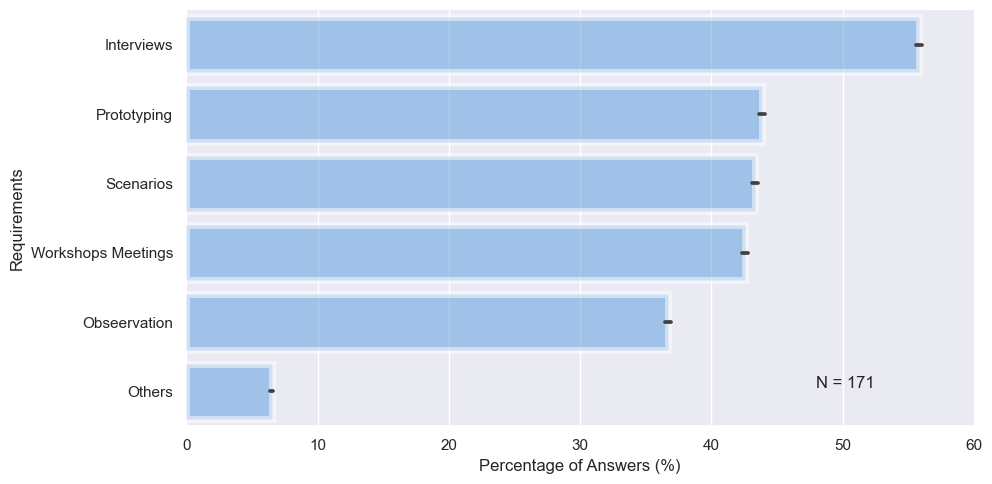

In [22]:
q9_boot_plot.single_barplot(x_axis="Value", y_axis="Requirements", 
                       # title="Bootstrapping - 95% Confidence \n How were requirements typically elicited in the ML-enabled system projects you participated in?",
                       title="",
                            x_label="Percentage of Answers (%)", y_label="Requirements", x_label_rotation=0, color="#429bf5",
                       total_answers=total_answers)

In [23]:
# confidence for each option
print("Option: (Lower Value, Mean, Upper Value)")
tuples = []
for idx in bootstrapped_dict_data:
    tuples.append((idx, bootstrapped_dict_data[idx]['confidence'][1]))
    print(idx + ':' + str(bootstrapped_dict_data[idx]['confidence']))

Option: (Lower Value, Mean, Upper Value)
Interviews:(0.5554759482982734, 0.5578713450292397, 0.5602667417602061)
Scenarios:(0.43100644189212867, 0.433327485380117, 0.43564852886810534)
Prototyping:(0.4362185156482087, 0.43859649122807015, 0.4409744668079316)
Workshops_Meetings:(0.423103290660825, 0.42554385964912284, 0.42798442863742064)
Observation:(0.36445649670791336, 0.3667894736842105, 0.36912245066050764)
Others:(0.06378766227322899, 0.06488304093567251, 0.06597841959811604)


In [24]:
from operator import itemgetter
tuples_sorted = sorted(tuples, key=itemgetter(1))

for ts in tuples_sorted[::-1]:
    print(ts[0] + ',' + str(round((ts[1] * 100), 2)))

Interviews,55.79
Prototyping,43.86
Scenarios,43.33
Workshops_Meetings,42.55
Observation,36.68
Others,6.49


In [25]:
# confidence for each option
print("Option: (Lower Value, Mean, Upper Value)")
for idx in bootstrapped_dict_data:
    print(idx + ':: P = ' + str(round((bootstrapped_dict_data[idx]['confidence'][1] * 100), 3)) + " [" + str(round((bootstrapped_dict_data[idx]['confidence'][0] * 100), 3)) + ", " + str(round((bootstrapped_dict_data[idx]['confidence'][2] * 100), 3)) + "]")

Option: (Lower Value, Mean, Upper Value)
Interviews:: P = 55.787 [55.548, 56.027]
Scenarios:: P = 43.333 [43.101, 43.565]
Prototyping:: P = 43.86 [43.622, 44.097]
Workshops_Meetings:: P = 42.554 [42.31, 42.798]
Observation:: P = 36.679 [36.446, 36.912]
Others:: P = 6.488 [6.379, 6.598]
